In [483]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [514]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, j, w, J, sample_sz, min_leaf=5, M=8, C=5):
        np.random.seed(42)
        self.j, self.w, self.J, self.M, self.C = j, w, J, M, C
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = []
        for i in range(n_trees):
            self.trees.append(self.create_tree())
            print(i)

    def create_tree(self):
        idxs = np.random.choice(self.x.index,len(self.x))
        xd = self.x.iloc[idxs,:]
        yd = self.y.iloc[idxs,:]
        return DecisionTree(xd, yd, idxs, self.j, self.w, self.J, self.min_leaf, self.M, self.C)
    
    def calc_surv(self,t,St,time):
        for k,tk in enumerate(time):
            if tk >= t : return St[k]
        return 0.0
    
    def aggregate_surv(self,S,times):
        ts = set(np.array(times).flatten())
        surv_prob = {}
        for t in ts:
            surv_prob[t] = np.mean([self.calc_surv(t,S[b],times[b]) for b in range(self.n_trees)])
        return surv_prob
    
    def predict(self, x):
        Hs_lst,Sts_lst,Times_lst = [],[],[]
        for tree in self.trees:
            Hs,Sts,Times = tree.predict(x)
            Hs_lst.append(Hs)
            Sts_lst.append(Sts)
            Times_lst.append(Times)
        surv_probs = []
        for i in range(len(x)):
            surv = self.aggregate_surv([Sts_lst[b][i] for b in range(self.n_trees)],[Times_lst[b][i] for b in range(self.n_trees)])
            surv_probs.append(surv)
        return surv_probs

In [515]:
class DecisionTree():
    def __init__(self, x, y, idxs, j, w, J, min_leaf=5, M=8, C=5):
        self.x, self.y, self.idxs, self.min_leaf, self.M, self.C = x, y, idxs, min_leaf, M, C
        self.j, self.w, self.J = j, w, J
        self.n, self.num_cols = len(idxs), x.shape[1]
        self.var_idx = None
        self.split = None
        self.score = -float('inf')
        self.left = None
        self.right = None
        
        self.find_varsplit()
        # self.var_idx, self.split, self.score --> contain split info for this node.
        
    def terminal_node_estimations(self):
        times = sorted(list(set(self.y[['futime']].iloc[self.idxs,0])))
        m = len(times)
        N,D,Yt = np.zeros((self.J+1,m)),np.zeros((self.J+1,m)),np.zeros((m,))
        for k,t in enumerate(times):
            for i in self.idxs:
                if self.y[['futime']].iloc[i,0] >= t :
                    Yt[k] += 1
                if self.y[['futime']].iloc[i,0] <= t :
                    N[int(self.y[['status']].iloc[i,0])][k] += 1
                if self.y[['futime']].iloc[i,0] == t :
                    D[int(self.y[['status']].iloc[i,0])][k] += 1
        Dt = np.sum(D,0)
        Nt = np.sum(N,0)
        ### Nelson–Aalen estimator for the cumulative event-specific hazard function H
        ### Kaplan–Meier estimator for the event-free survival function St
        H = D/Yt 
        St = 1 - Dt/Yt
        for k in range(1,m):
            H[:,k] += H[:,k-1] 
            St[k] *= St[k-1]
            
        self.H, self.St, self.times = H,St,times
        plt.plot(times,St)
        plt.show()
        
    def find_varsplit(self):
        if len(set(self.idxs)) <= self.min_leaf :
            self.terminal_node_estimations()
            return
        for var_idx in np.random.choice(self.x.shape[1],self.M):
            for c in np.random.choice(self.x.iloc[self.idxs,var_idx],self.C):
                while c==max(self.x.iloc[self.idxs,var_idx]):
                    c = np.random.choice(self.x.iloc[self.idxs,var_idx])
                lr = self.calc_logrank(var_idx,c,self.j,self.w[self.j])
                print(len(set(self.idxs)), lr)
                if lr > self.score:
                    self.score, self.var_idx, self.split = lr, var_idx, c
                    
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        print(self.split,len(lhs),len(rhs))
        
        self.left = DecisionTree(self.x, self.y, self.idxs[lhs], self.j, self.w, self.J, self.min_leaf, self.M, self.C)
        self.right = DecisionTree(self.x, self.y, self.idxs[rhs], self.j, self.w, self.J, self.min_leaf, self.M, self.C)
        
    def calc_logrank(self,var_idx, c, j, wj):
        if wj == 0: return 0.0
        times = sorted(list(set(self.y[['futime']].iloc[self.idxs,0])))
        m = len(times)
        Y_l,Y_r,dj_l,dj_r = np.zeros((m,)),np.zeros((m,)),np.zeros((m,)),np.zeros((m,))
        for k,t in enumerate(times):
            for i in self.idxs:
#                 if t == times[-1]:
#                     print(t,self.y[['futime']].iloc[i,0])
                if self.y[['futime']].iloc[i,0] >= t :
                    if self.x.iloc[i,var_idx] <= c :
                        Y_l[k] += 1
                    else :
                        Y_r[k] += 1
                if self.y[['futime']].iloc[i,0] == t and self.y[['status']].iloc[i,0] == float(j) :
                    if self.x.iloc[i,var_idx] <= c :
                        dj_l[k] += 1
                    else :
                        dj_r[k] += 1
        Y = Y_l + Y_r
        dj = dj_l + dj_r
        Wj = np.array([wj]*m)
#         print(Y)
        sigj = np.sum((Wj**2)*dj*(Y_l/Y)*(1 - Y_l/Y)*((Y-dj)/(Y-1))) if (0.0 not in Y-1 and 0.0 not in Y) else 1.0*10**9
        Lj = np.sum(Wj*(dj_l - dj*Y_l/Y))/sigj if (0.0 not in Y and sigj!=0.0) else 1.0*10**10
        
        return abs(Lj)
        
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x): ## x --> numpy array
        Hs,Sts,Times = [],[],[]
        for xi in x:
            H,St,times = self.predict_row(xi)
            Hs.append(H)
            Sts.append(St)
            Times.append(times)
        return Hs,Sts,Times

    def predict_row(self, xi):
        if self.is_leaf: return self.H,self.St,self.times
        tree = self.left if xi[self.var_idx]<=self.split else self.right
        return tree.predict_row(xi)

In [516]:
# id       = case number
# futime   = number of days between registration and the earlier of death,
#            transplantion, or study analysis time in July, 1986
# status   = 0=alive(censored), 1=liver transplant, 2=dead
# drug     = 1= D-penicillamine, 2=placebo
# age      = age in days
# sex      = 0=male, 1=female
# ascites  = presence of ascites: 0=no 1=yes
# hepato   = presence of hepatomegaly 0=no 1=yes
# spiders  = presence of spiders 0=no 1=yes
# edema    = presence of edema 0=no edema and no diuretic therapy for edema;
#           .5 = edema present without diuretics, or edema resolved by diuretics;
#            1 = edema despite diuretic therapy
# bili     = serum bilirubin in mg/dl
# chol     = serum cholesterol in mg/dl
# albumin  = albumin in gm/dl
# copper   = urine copper in ug/day
# alk_phos = alkaline phosphatase in U/liter
# sgot     = SGOT in U/ml
# trig     = triglicerides in mg/dl
# platelet = platelets per cubic ml/1000
# protime  = prothrombin time in seconds
# stage    = histologic stage of disease

In [517]:
cols = ['id','futime','status','drug','age','sex','ascites','hepato','spiders','edema','bili','chol','albumin','copper','alk_phos','sgot','trig','platelet','protime','stage']

In [518]:
df = pd.DataFrame(columns=cols)
with open('pbc.dat.txt','r') as f:
    for line in f.readlines():
        row = [float(n) if n!='.' else np.nan for n in line.split()]
        df.loc[len(df.index)] = row

In [519]:
u,c = np.unique(df['futime'].values,return_counts = True)
freq = {t:f for t,f in zip(u,c)}

In [520]:
df2 = df.copy()

In [521]:
for k in list(freq.keys())[::-1]:
    if freq[k] > 1:
        break
    df2 = df2.drop(df2[df2['futime']==k].index)
df2 = df2.reset_index().drop(columns=['index'])

X,y = df2.drop(columns=['id','futime','status']),df2[['futime','status']]
X,y = X.interpolate(),y.interpolate()

221 1.9055793454286938
221 1.214692987058097
15612.0 95 276
54 0.22024791601128524
54 0.007107862990329944
3.2 10 85


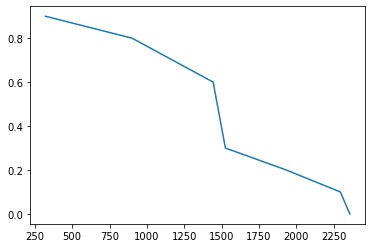

47 1.7859917414808013
47 1.7859917414808013
2.0 33 52
17 0.0
17 0.0
76.0 16 17


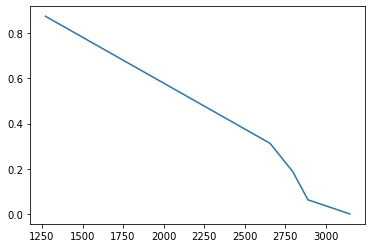

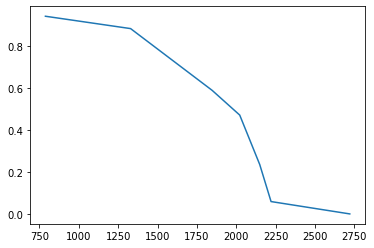

30 10000000000.0
30 1.3226210499502458
190.0 50 2
28 2.8250160925754955
28 0.7361585727239147
184.45 44 6
25 9.910363425251798
25 1.5672176373027575
194.0 40 4
23 1.5462305446107802
23 1.2384399664755077
855.0 13 27


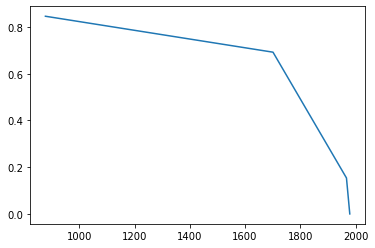

17 1.2857142857142858
17 1.588235294117647
14558.0 17 10


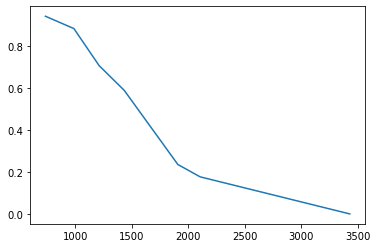

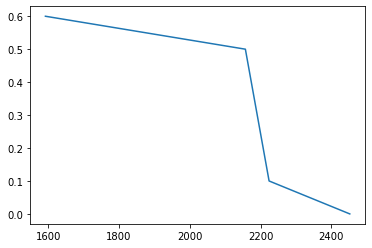

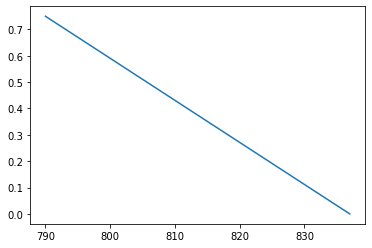

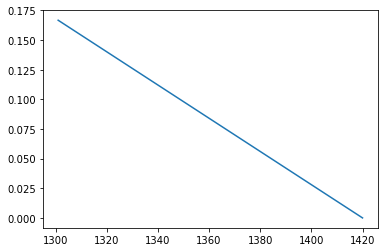

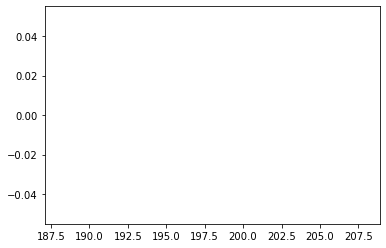

167 1.8584178293806282
167 1.058370781600895
3.0 193 83
120 1.7155172413793104e-09
120 1.7155172413793104e-09
0.0 83 110
53 0.0
53 0.0
1.0 42 41
25 0.0
25 0.0
1132.0 23 19


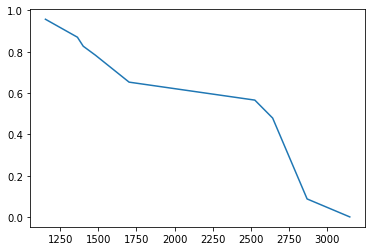

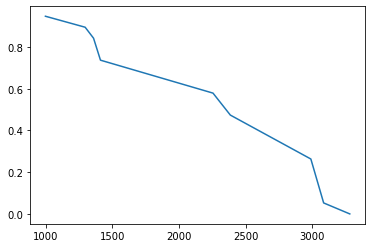

In [ ]:
forest = TreeEnsemble(x=X, y=y, n_trees=10, j=1, w={1:1,2:0}, J=2, sample_sz=len(X), min_leaf=15, M=1, C=2)